In [40]:
# use raw time-domain speech signal as input to cnn for SER

import numpy as np
import os
import librosa


datapath = 'emodb/'
classes = ['W','L','E','A','F','T','N'] # 7 classes

seg_len = 16000 # signal split length (in samples) in time domain
seg_ov = int(seg_len*0.5) # 50% overlap

def normalize(s):
# RMS normalization
	new_s = s/np.sqrt(np.sum(np.square((np.abs(s))))/len(s))
	return new_s

def countclasses(fnames):
	dict = {classes[0]:0,classes[1]:0,classes[2]:0,classes[3]:0,classes[4]:0,classes[5]:0,classes[6]:0}
	for name in fnames:
		if name[5] in classes:
			dict[name[5]]+=1
	return dict

def data1d(path):

	fnames = os.listdir(datapath)
	dict = countclasses(fnames)
	print('Total Data',dict)
	num_cl = len(classes)
	train_dict = {classes[0]:0,classes[1]:0,classes[2]:0,classes[3]:0,classes[4]:0,classes[5]:0,classes[6]:0}
	test_dict = {classes[0]:0,classes[1]:0,classes[2]:0,classes[3]:0,classes[4]:0,classes[5]:0,classes[6]:0}
	val_dict = {classes[0]:0,classes[1]:0,classes[2]:0,classes[3]:0,classes[4]:0,classes[5]:0,classes[6]:0}

	for i in range(num_cl):
		cname =  list(dict.keys())[i]
		cnum = dict[cname]
		t = round(0.8*cnum)
		test_dict[cname] = int(cnum - t)
		val_dict[cname] = int(round(0.2*t))
		train_dict[cname] = int(t - val_dict[cname])
		print('Class:',cname,'train:',train_dict[cname],'val:',val_dict[cname],'test:',test_dict[cname])
		
	x_train = []
	y_train = []
	x_test = []
	y_test = []
	x_val = []
	y_val = []

	count = {classes[0]:0,classes[1]:0,classes[2]:0,classes[3]:0,classes[4]:0,classes[5]:0,classes[6]:0}

	for name in fnames:
		if name[5] in classes:
			sig,fs = librosa.load(datapath+'/'+name, sr=16000)
			# normalize signal
			data = normalize(sig)
			if(len(data) < seg_len):
				pad_len = int(seg_len - len(data))
				pad_rem = int(pad_len % 2)
				pad_len /= 2
				signal = np.pad(data,(int(pad_len), int(pad_len+pad_rem)),'constant',constant_values=0)
			elif(len(data) > seg_len):
				signal = []
				end = seg_len
				st = 0
				while(end < len(data)):
					signal.append(data[st:end])
					st = st + seg_ov
					end = st + seg_len
				signal = np.array(signal)
				if(end >= len(data)):
					num_zeros = int(end-len(data))
					if(num_zeros > 0):
						n1 = np.array(data[st:end])
						n2 = np.zeros([num_zeros])
						s = np.concatenate([n1,n2],0)
					else:
						s = np.array(data[int(st):int(end)])
				signal = np.vstack([signal,s])
			else:
				signal = data

			if(count[name[5]] < train_dict[name[5]]):
				if(signal.ndim>1):
					for i in range(signal.shape[0]):						
						x_train.append(signal[i])
						y_train.append(name[5])
				else:
					x_train.append(signal)
					y_train.append(name[5])
			else:
				if((count[name[5]]-train_dict[name[5]]) < val_dict[name[5]]):
					if(signal.ndim>1):
						for i in range(signal.shape[0]):							
							x_val.append(signal[i])
							y_val.append(name[5])
					else:
						x_val.append(signal)
						y_val.append(name[5])
				else:
					if(signal.ndim>1):
						for i in range(signal.shape[0]):
							x_test.append(signal[i])
							y_test.append(name[5])
					else:
						x_test.append(signal)
						y_test.append(name[5])
			count[name[5]]+=1
	return np.float32(x_train),y_train,np.float32(x_test),y_test,np.float32(x_val),y_val

def string2num(y):
	y1 = []
	for i in y:
		if(i == classes[0]):
			y1.append(0)
		elif(i == classes[1]):
			y1.append(1)
		elif(i == classes[2]):
			y1.append(2)
		elif(i == classes[3]):
			y1.append(3)
		elif(i == classes[4]):
			y1.append(4)
		elif(i == classes[5]):
			y1.append(5)
		else:
			y1.append(6)
	y1 = np.float32(np.array(y1))
	return y1

def load_data():
	x_tr,y_tr,x_t,y_t,x_v,y_v = data1d(datapath)
	y_tr = string2num(y_tr)
	y_t = string2num(y_t)
	y_v = string2num(y_v)
	return x_tr, y_tr, x_t, y_t, x_v, y_v

Total Data {'W': 127, 'L': 81, 'E': 46, 'A': 69, 'F': 71, 'T': 62, 'N': 79}
Class: W train: 82 val: 20 test: 25
Class: L train: 52 val: 13 test: 16
Class: E train: 30 val: 7 test: 9
Class: A train: 44 val: 11 test: 14
Class: F train: 46 val: 11 test: 14
Class: T train: 40 val: 10 test: 12
Class: N train: 50 val: 13 test: 16
Model: "Emo1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_28 (Conv1D)          (None, 16000, 64)         256       
                                                                 
 batch_normalization_28 (Ba  (None, 16000, 64)         256       
 tchNormalization)                                               
                                                                 
 activation_28 (Activation)  (None, 16000, 64)         0         
                                                                 
 max_pooling1d_28 (MaxPooli  (None, 4000, 64)          0         

e:\python\python\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


55/55 [==============================] - 84s 1s/step - loss: 1.5459 - categorical_accuracy: 0.4137 - val_loss: 1.6174 - val_categorical_accuracy: 0.4159
Epoch 2/1500
55/55 [==============================] - ETA: 0s - loss: 1.1229 - categorical_accuracy: 0.5730
Epoch 2: val_categorical_accuracy did not improve from 0.41587
55/55 [==============================] - 72s 1s/step - loss: 1.1229 - categorical_accuracy: 0.5730 - val_loss: 1.6551 - val_categorical_accuracy: 0.4111
Epoch 3/1500
55/55 [==============================] - ETA: 0s - loss: 0.9766 - categorical_accuracy: 0.6249
Epoch 3: val_categorical_accuracy improved from 0.41587 to 0.41827, saving model to best_model.h5
55/55 [==============================] - 73s 1s/step - loss: 0.9766 - categorical_accuracy: 0.6249 - val_loss: 1.5168 - val_categorical_accuracy: 0.4183
Epoch 4/1500
55/55 [==============================] - ETA: 0s - loss: 0.8824 - categorical_accuracy: 0.6647
Epoch 4: val_categorical_accuracy did not improve from 0

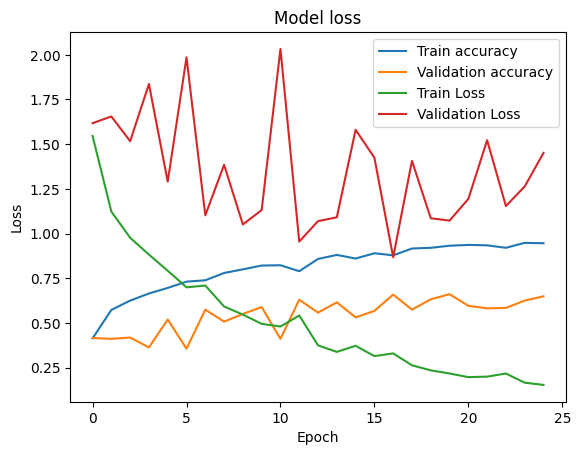

In [41]:
# 1D cnn for SER

from keras.models import Model,Sequential
from keras import optimizers
from keras.layers import Input,Conv1D,BatchNormalization,MaxPooling1D,LSTM,Dense,Activation,Layer,Bidirectional
#from emodata1d import load_data
from keras.utils import to_categorical
import keras.backend as K
#import argparse
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.models import load_model

def emo1d(input_shape, num_classes):
	num_fc = 64
	batch_size = 32
	num_epochs = 1500 #best model will be saved before number of epochs reach this value
	learning_rate = 0.0001
	decay = 1e-6
	momentum = 0.9
	
	model = Sequential(name='Emo1D')
	
	# LFLB1
	model.add(Conv1D(filters = 64,kernel_size = (3),strides=1,padding='same',data_format='channels_last',input_shape=input_shape))	
	model.add(BatchNormalization())
	model.add(Activation('elu'))
	model.add(MaxPooling1D(pool_size = 4, strides = 4))

	#LFLB2
	model.add(Conv1D(filters=64, kernel_size = 3, strides=1,padding='same'))
	model.add(BatchNormalization())
	model.add(Activation('elu'))
	model.add(MaxPooling1D(pool_size = 4, strides = 4))

	#LFLB3
	model.add(Conv1D(filters=128, kernel_size = 3, strides=1,padding='same'))
	model.add(BatchNormalization())
	model.add(Activation('elu'))
	model.add(MaxPooling1D(pool_size = 4, strides = 4))

	#LFLB4
	model.add(Conv1D(filters=128, kernel_size = 3, strides=1,padding='same'))
	model.add(BatchNormalization())
	model.add(Activation('elu'))
	model.add(MaxPooling1D(pool_size = 4, strides = 4))

	#LSTM
	model.add(Bidirectional(LSTM(units=num_fc))) 
		
	#FC
	model.add(Dense(units=num_classes,activation='softmax'))

	#Model compilation	
	#opt = optimizers('adam'lr = learning_rate, nesterov=True)
	model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['categorical_accuracy'])
	
	return model


def train(model,x_tr,y_tr,x_val,y_val):
	num_fc = 64
	batch_size = 32
	num_epochs = 1500 #best model will be saved before number of epochs reach this value
	learning_rate = 0.0001
	decay = 1e-6
	momentum = 0.9
	
	es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=8)
	mc = ModelCheckpoint('best_model.h5', monitor='val_categorical_accuracy', mode='max', verbose=1, save_best_only=True)
	history = model.fit(x_tr,y_tr,epochs=num_epochs,batch_size=batch_size,validation_data=(x_val,y_val),callbacks=[es, mc])
	plt.plot(history.history['categorical_accuracy'], label='Train accuracy')
	plt.plot(history.history['val_categorical_accuracy'], label='Validation accuracy')
	plt.title('Model accuracy curve')
	plt.ylabel('categorical accuracy')
	plt.xlabel('Epoch')
	plt.legend()


	plt.plot(history.history['loss'], label='Train Loss')
	plt.plot(history.history['val_loss'], label='Validation Loss')
	plt.title('Model loss')
	plt.ylabel('Loss')
	plt.xlabel('Epoch')
	plt.legend()

	print(" best validation accuracy is   ",max(history.history['val_categorical_accuracy']))


	return model

def test(model,x_t,y_t):

	saved_model = load_model('best_model.h5')
	score = saved_model.evaluate(x_t,y_t,batch_size=20)
	print(score)
	return score

def loadData():

	x_tr,y_tr,x_t,y_t,x_val,y_val = load_data()
	x_tr = x_tr.reshape(-1,x_tr.shape[1],1)
	x_t = x_t.reshape(-1,x_t.shape[1],1)
	x_val = x_val.reshape(-1,x_val.shape[1],1)
	y_tr = to_categorical(y_tr)
	y_t = to_categorical(y_t)
	y_val = to_categorical(y_val)
	return x_tr,y_tr,x_t,y_t,x_val,y_val

if __name__ == "__main__":

	import numpy as np
	import matplotlib.pyplot as plt

	
	#load data	
	x_tr,y_tr,x_t,y_t,x_val,y_val = loadData()	
	
	num_fc = 64
	batch_size = 32
	num_epochs = 1500 #best model will be saved before number of epochs reach this value
	learning_rate = 0.0001
	decay = 1e-6
	momentum = 0.9

	#define model
	model = emo1d(input_shape=x_tr.shape[1:],num_classes=len(np.unique(np.argmax(y_tr, 1))))
	model.summary()

	#train model
	model = train(model,x_tr,y_tr,x_val,y_val)
	
	#test model
	score = test(model,x_t,y_t)